# 🧪 Diffusion Models for Medical Anomaly Detection
Welcome to the tutorial session on diffusion models for anomaly detection. In this exercise, you'll work with real MRI datasets and a pretrained AnoDDPM model to understand how noise-based generative models can help detect abnormalities in medical scans.

---
**🗓️ Deadline:** Please complete and submit your work by **Friday, May 16th, 2025**.

**📩 Submission:** Upload a **PDF report** and the **Final Notebook** via Moodle.

**📬 Contact for help:** [cosmin.bercea@tum.de](mailto:cosmin.bercea@tum.de)

---
### ✅ What you need to deliver:
- A PDF with:
  - Plots showing reconstructions, anomaly maps, and denoising steps
  - Short answers to conceptual questions
- The final notebook with:
  - Code outputs for each section
    - Feel free to comment code and write interpretations.

In [34]:
# @title
# 克隆正确的仓库
!git clone https://github.com/compai-lab/AIM_S25_diffusion_tutorial.git

# 切换到克隆的仓库目录
%cd AIM_S25_diffusion_tutorial

# 列出目录内容以确认
!ls

Cloning into 'AIM_S25_diffusion_tutorial'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 5), reused 38 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 8.11 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/AIM_S25_diffusion_tutorial/AIM_S25_diffusion_tutorial
configs  Diffusion_Tutorial.ipynb  images  model


## 🌌 Diffusion Models: An Overview

Diffusion models are a class of generative models that learn to reverse a gradual noising process applied to data. They are inspired by physical diffusion processes, where particles spread out over time. In the context of machine learning, diffusion models are used to generate data by progressively denoising a sample of pure noise.

### 🌀 How Diffusion Models Work:
1. **Forward Process (Noising):**
    - The forward process involves adding noise to the data in small increments over a series of time steps.
    - At each step, the data becomes slightly noisier, eventually turning into pure noise.
    - This process is modeled as a Markov chain, where the state at each step depends only on the previous state.

2. **Reverse Process (Denoising):**
    - The reverse process learns to undo the noising process step by step.
    - Starting from pure noise, the model generates data by iteratively removing noise.
    - The reverse process is also modeled as a Markov chain, but it requires learning the conditional probabilities of the data at each step.

3. **Training:**
    - The model is trained to predict the noise added at each step of the forward process.
    - By minimizing the difference between the predicted and actual noise, the model learns to reconstruct the original data.

4. **Sampling:**
    - To generate new data, the model starts with a random noise sample and applies the learned reverse process.
    - This iterative denoising process produces realistic samples that resemble the training data.

## 🐾 Diffusion Process

The image below illustrates the diffusion process applied to an image containing two dogs. It demonstrates the following key points:

1. **Forward and Backward Process**:  
    - The forward process involves progressively adding noise to the image, eventually turning it into pure noise.  
    - The backward process involves removing noise step-by-step to reconstruct the original image.  
    - Since the process is probabilistic, the sampled image would look (slightly) different than the input image, depending on the amount of lost information (noise forward steps) that are being done.

2. **Relevance to Anomaly Detection**:
    - In anomaly detection, starting from random noise can lead to reconstructions that deviate significantly from the original image.
    - Instead, the process begins from a specific timestep (`t`) to ensure that the reconstruction aligns closely with the input image, enabling effective anomaly localization.


![Diffusion Process](https://github.com/compai-lab/AIM_S25_diffusion_tutorial/blob/main/images/fig_diffusion.png?raw=1)

## 🧠 Example: Anomaly Detection with Diffusion Models

This example demonstrates how diffusion models can be utilized for anomaly detection in medical imaging. By leveraging the ability of diffusion models to reconstruct pseudo-healthy images, we can identify anomalies as deviations between the input and reconstructed images. The process involves:

1. **Adding Noise**: Gradually adding noise to the input image to simulate the forward diffusion process.
2. **Denoising**: Using the learned reverse diffusion process to reconstruct the pseudo-healthy image.
3. **Anomaly Mapping**: Computing the absolute difference between the input and reconstructed images to highlight anomalies.

### 🧠 Key Advantages:
- **High-Quality Generation:** Diffusion models produce high-quality samples, often surpassing other generative models like GANs.
- **Stable Training:** Unlike GANs, diffusion models do not suffer from mode collapse or unstable training dynamics.
- **Generalization:** They can be applied to various anomaly types since the model is only trained on healthy images.

In this notebook, you'll explore how diffusion models can be used to detect anomalies in medical images by leveraging their ability to reconstruct healthy data distributions.

![AutoDDPM](https://github.com/compai-lab/AIM_S25_diffusion_tutorial/blob/main/images/method.gif?raw=1)

This approach is inspired by the work of Bercea et al., which explores the use of automatic diffusion models for enhancing robustness and generalizability in anomaly detection. For more details, refer to the paper: [AutoDDPM [1]](https://arxiv.org/pdf/2305.19643) or check our latest published anomaly detection method [THOR [2]](https://arxiv.org/pdf/2403.08464) (see teaser below)

*[1] Bercea CI, Neumayr M, Rueckert D, Schnabel JA. Mask, Stitch, and Re-Sample: Enhancing Robustness and Generalizability in Anomaly Detection through Automatic Diffusion Models. In ICML 3rd Workshop on Interpretable Machine Learning in Healthcare (IMLH).*

*[2] Bercea CI, Wiestler B, Rueckert D, Schnabel JA. Diffusion models with implicit guidance for medical anomaly detection. In International Conference on Medical Image Computing and Computer-Assisted Intervention 2024 Oct 3 (pp. 211-220). Cham: Springer Nature Switzerland.*


![THOR](https://github.com/compai-lab/AIM_S25_diffusion_tutorial/blob/main/images/fig_teaser.png?raw=1)

## 🧰 Setup: Install Packages, Load Data & Pretrained Model
This section loads the required packages and datasets (IXI, ATLAS), and loads a pretrained AnoDDPM model.

**Note:** Make sure runtime has internet access for pip installation (Colab/Kaggle etc).

In [35]:
# @title
!pip install pytorch-lightning # ONLY IN GOOGLE COLAB
# Step 1: Setup
# Import Required Libraries
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


# Check GPU availability for Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 🗂️ BrainDataset Class: Dataset for Brain Images and Masks
This class is designed to load brain MRI images and their corresponding masks from a specified directory. It facilitates preprocessing and provides the data in a format suitable for PyTorch models.

#### Key Features:
- **Initialization (`__init__`)**: Takes the path to the dataset directory and identifies image-mask pairs.
- **Length (`__len__`)**: Returns the total number of image-mask pairs in the dataset.
- **Get Item (`__getitem__`)**: Loads an image-mask pair at a given index, normalizes the data to [0, 1], and converts it to PyTorch tensors.

#### Usage:
This class is used to create a dataset object, which can then be passed to a DataLoader for batching and shuffling during training or evaluation.

In [36]:
# @title
 #Preprocessing: Load Images and Corresponding Masks
class BrainDataset(Dataset):
    def __init__(self, data_dir):
        """
        Dataset class for loading brain images and corresponding masks.

        Args:
        - data_dir (str): Path to the dataset directory containing images and masks.
        """
        self.data_dir = data_dir
        self.image_paths = [
            os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if "mask" not in fname and fname.endswith(".png")
        ]
        self.mask_paths = [
            img_path.replace(".png", "_mask.png") for img_path in self.image_paths
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads an image-mask pair at the given index.

        Args:
        - idx (int): Index of the image-mask pair.

        Returns:
        - img (torch.Tensor): Image tensor (H, W).
        - mask (torch.Tensor): Corresponding mask tensor (H, W).
        """
        # Load image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = imread(img_path, as_gray=True).astype(np.float32)  # Load grayscale image
        mask = imread(mask_path, as_gray=True).astype(np.float32)  # Load grayscale mask

        # Normalize image to [0, 1]
        img /= 255.0
        mask /= 255.0

        # Convert to PyTorch tensors
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

### 📂 Dataset Download: ATLAS Stroke Lesion Dataset
The dataset used in this notebook is the **ATLAS Stroke Lesion Dataset**, which contains annotated brain MRI scans for stroke lesion segmentation. It is a valuable resource for training and evaluating models in medical imaging tasks, particularly for anomaly detection and segmentation.

For more details about the dataset, visit the official website: [ATLAS Dataset](https://fcon_1000.projects.nitrc.org/indi/retro/atlas.html).

In [40]:
# @title
# Step 2: Dataset Setup
# Download the dataset
!wget -O dataset.zip https://syncandshare.lrz.de/dl/fi99En3eCa6MtmBYAHJ4EQ/Atlas_train_.zip
!unzip -qq dataset.zip -d ./data

--2025-05-14 21:47:34--  https://syncandshare.lrz.de/dl/fi99En3eCa6MtmBYAHJ4EQ/Atlas_train_.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6575511 (6.3M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   6.27M   396KB/s    in 17s     

2025-05-14 21:47:53 (371 KB/s) - ‘dataset.zip’ saved [6575511/6575511]



### 🖼️ Visualizing Image-Mask Pairs
This code snippet demonstrates how to load and visualize a batch of brain MRI images and their corresponding masks using the `BrainDataset` class and a PyTorch DataLoader.

#### Key Steps:
1. **Dataset Initialization**:
    - The `BrainDataset` is instantiated with the path to the dataset directory.
    - A DataLoader is created to batch and shuffle the dataset.

2. **Visualization Function**:
    - The `show_image_mask_pairs` function takes a batch of images and masks, displaying them side-by-side in a grid format.

3. **Sample Visualization**:
    - A sample batch is retrieved from the DataLoader and passed to the visualization function to display the images and their corresponding masks.


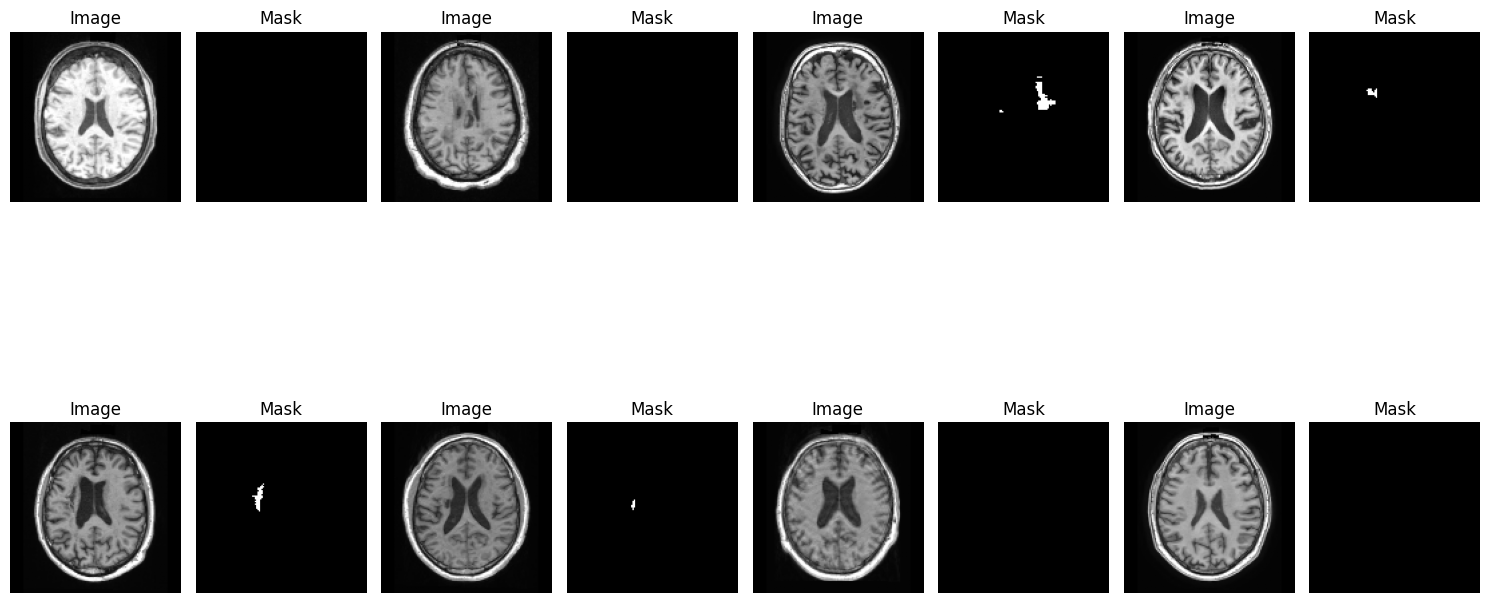

In [41]:
# @title
# Usage Example:
data_dir = "./data/Atlas_train_"  # Path to the dataset directory
dataset = BrainDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Visualize a sample batch
def show_image_mask_pairs(batch, ncols=4):
    """
    Visualizes image-mask pairs from a batch.

    Args:
    - batch (tuple): A tuple containing image tensors and mask tensors.
    - ncols (int): Number of columns in the visualization grid.
    """
    images, masks = batch
    nrows = (len(images) + ncols - 1) // ncols

    plt.figure(figsize=(15, 5 * nrows))
    for idx in range(len(images)):
        plt.subplot(nrows, ncols * 2, idx * 2 + 1)
        plt.imshow(images[idx].squeeze().cpu().numpy(), cmap="gray")
        plt.title("Image")
        plt.axis("off")

        plt.subplot(nrows, ncols * 2, idx * 2 + 2)
        plt.imshow(masks[idx].squeeze().cpu().numpy(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize a sample batch from the dataloader
sample_batch = next(iter(dataloader))
show_image_mask_pairs(sample_batch)

### ⚠️ Caution: Definition of 'Healthy' Images

The function below selects images without visible lesions in their corresponding masks and labels them as 'healthy' for this exercise.

⚠️ **Important Note:** These images are not truly 'healthy' as they are part of a full 3D volume that includes a lesion. However, the selected slices do not show signs of active stroke. For the purpose of this exercise, they are treated as 'healthy' to avoid domain shift issues when working with datasets from different scanners or domains.

This approach is specific to this tutorial and should not be generalized to other medical imaging tasks or datasets.

In [ ]:
# @title
def split_healthy_and_stroke(dataset):
    """
    Splits the dataset into healthy and stroke cases based on the masks.

    Args:
    - dataset (Dataset): An instance of the BrainDataset.

    Returns:
    - healthy_indices (list): List of indices corresponding to healthy cases.
    - stroke_indices (list): List of indices corresponding to stroke cases.
    """
    healthy_indices = []
    stroke_indices = []

    for idx in range(len(dataset)):
        _, mask = dataset[idx]  # Load the mask
        if torch.any(mask > 0):  # Check if any pixel in the mask is highlighted
            stroke_indices.append(idx)
        else:
            healthy_indices.append(idx)

    return healthy_indices, stroke_indices

# Example Usage:
healthy_total_indices, stroke_total_indices = split_healthy_and_stroke(dataset)
# Split indices for healthy dataset
healthy_train_indices = healthy_total_indices[:-32]  # All but the last 32
healthy_test_indices = healthy_total_indices[-32:]  # Last 32

# Split indices for stroke dataset
stroke_train_indices = stroke_total_indices[:-32]  # All but the last 32
stroke_test_indices = stroke_total_indices[-32:]  # Last 32

# Create training and testing subsets
healthy_train_dataset = torch.utils.data.Subset(dataset, healthy_train_indices)
healthy_test_dataset = torch.utils.data.Subset(dataset, healthy_test_indices)

stroke_train_dataset = torch.utils.data.Subset(dataset, stroke_train_indices)
stroke_test_dataset = torch.utils.data.Subset(dataset, stroke_test_indices)

# Print dataset sizes
print(f"Healthy Train Size: {len(healthy_train_dataset)}, Healthy Test Size: {len(healthy_test_dataset)}")
print(f"Stroke Train Size: {len(stroke_train_dataset)}, Stroke Test Size: {len(stroke_test_dataset)}")

# Visualize samples from the training set
sample_batch = next(iter(DataLoader(healthy_test_dataset, batch_size=4, shuffle=True)))
show_image_mask_pairs(sample_batch)

# 🚀 Student Exercises Begin Here
From this point onward, you will implement and run the required tasks. Follow the instructions provided in each section, and make sure to document your observations and results.

### 📝 Instructions:
- Carefully read the task descriptions.
- Implement the required code in the provided cells.
- Run the code and analyze the outputs.
- Write short reflections or answers in markdown cells where prompted.

Good luck, and enjoy the learning process!

## 🔁 Forward Process: Gaussian vs Simplex Noise
In this task, you'll simulate and compare the effect of Gaussian vs. Simplex noise on a dummy image.

## 🧪 Exercise 1:
- Apply increasing noise levels (e.g., t=0.1, 0.5, 1.0, 2.0) for both Gaussian and Simplex.
- Visualize side-by-side.
- Comment on what you observe (e.g., with regard to the preservation of the original shape)

### 🔧 Code: Add Noise to Dummy Image
This function adds either Gaussian or Simplex noise to a synthetic circular image. You can control the noise type and strength using the `noise_type` and `noise_level` parameters.

In [6]:
# @title
# First, let's install the noise library if not already installed
!pip install noise

def add_noise_to_dummy_image(noise_type='gaussian', noise_level=0.5):
    """
    Create a circular image and add Gaussian or Simplex noise

    Parameters:
    - noise_type: Type of noise ('gaussian' or 'simplex')
    - noise_level: Strength of the noise

    Returns:
    - Original image and image with added noise
    """
    # Create circular image
    size = 128
    x, y = np.mgrid[:size, :size]
    center = size // 2
    radius = size // 4
    circle = ((x - center)**2 + (y - center)**2) <= radius**2
    img = np.zeros((size, size))
    img[circle] = 1.0

    # Add noise
    if noise_type == 'gaussian':
        # Gaussian noise
        noise = np.random.normal(0, noise_level, img.shape)
        noisy_img = img + noise
    else:  # True Simplex noise
        import noise

        # Generate simplex noise
        simplex_noise = np.zeros(img.shape)
        scale = 0.1 / noise_level  # Adjust scale based on noise level

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                # Generate 2D simplex noise
                simplex_noise[i, j] = noise.snoise2(i * scale, j * scale)

        # Scale the noise to match the noise level
        simplex_noise = simplex_noise * noise_level
        noisy_img = img + simplex_noise

    # Clip values to [0, 1] for visualization
    noisy_img = np.clip(noisy_img, 0, 1)

    return img, noisy_img

# Set different noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]

# Create figure
plt.figure(figsize=(12, 6))

# Display Gaussian noise
for i, level in enumerate(noise_levels):
    original, noisy = add_noise_to_dummy_image('gaussian', level)

    # Show original image only in first position
    if i == 0:
        plt.subplot(2, len(noise_levels) + 1, 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Show image with Gaussian noise
    plt.subplot(2, len(noise_levels) + 1, i + 2)
    plt.imshow(noisy, cmap='gray')
    plt.title(f"Gaussian, t={level}")
    plt.axis('off')

# Display Simplex noise
for i, level in enumerate(noise_levels):
    original, noisy = add_noise_to_dummy_image('simplex', level)

    # Add noise type label
    if i == 0:
        plt.subplot(2, len(noise_levels) + 1, len(noise_levels) + 2)
        plt.imshow(original, cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Show image with Simplex noise
    plt.subplot(2, len(noise_levels) + 1, len(noise_levels) + i + 3)
    plt.imshow(noisy, cmap='gray')
    plt.title(f"Simplex, t={level}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Observations
print("Observations:")
print("1. Gaussian noise adds random variations across the entire image, with noise magnitude increasing with t")
print("2. Simplex noise creates more structured, gradient-like variations with spatial coherence")
print("3. As noise level increases, Simplex noise appears to preserve the original shape better")
print("4. Simplex noise produces smoother transitions between light and dark areas compared to Gaussian noise")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp311-cp311-linux_x86_64.whl size=56278 sha256=c8355f2ab63d9b64b29c94100860ed07075852d610a5378babb6103ccf2526bb
  Stored in directory: /root/.cache/pip/wheels/39/25/2e/af6d1bcc91a8f99af0f651f8718b9ab999720a21c6d4149091
Successfully built noise


Observations:
1. Gaussian noise adds random variations across the entire image, with noise magnitude increasing with t
2. Simplex noise creates more structured, gradient-like variations with spatial coherence
3. As noise level increases, Simplex noise appears to preserve the original shape better
4. Simplex noise produces smoother transitions between light and dark areas compared to Gaussian noise


### 🧪 Optional: Improve Noise Visualizations
If you're curious, try using actual Perlin or Simplex noise with different coarseness levels and explore their effect.

📌 *Optional task to enhance your visual understanding.*

### 🚀 Loading AnoDDPM with Pre-Trained Weights
In this section, we will load the AnoDDPM model and initialize it with pre-trained weights. This step is crucial for leveraging the model's learned capabilities for anomaly detection in medical imaging tasks. The pre-trained weights have been trained on a healthy dataset (IXI), enabling the model to perform effectively without requiring additional training.

In [12]:
# @title
from model.ddpm import DDPM


### 🛠️ Configurations for DDPM
The configuration for the DDPM model is stored in the provided YAML files (e.g., `diffusion_config.yaml`). These files define key parameters such as noise type (Gaussian or Simplex), model architecture, and training settings.

If you wish to train different models or experiment with variations (e.g., switching between Gaussian and Simplex noise), you can modify these parameters directly in the YAML files before training.

In [13]:
# @title
import yaml
with open('./configs/diffusion_config.yaml', 'r') as f:
    diff_config = yaml.safe_load(f)
diff_config

{'spatial_dims': 2,
 'in_channels': 1,
 'out_channels': 1,
 'num_channels': [128, 256, 256],
 'attention_levels': [False, True, True],
 'num_res_blocks': 1,
 'num_head_channels': 256,
 'train_scheduler': 'ddpm',
 'inference_scheduler': 'ddpm',
 'inference_steps': 1000,
 'noise_level': 300,
 'noise_type': 'gaussian',
 'prediction_type': 'epsilon'}

In [14]:
# @title
anoddpm = DDPM(**diff_config)

### 📥 Downloading Pre-Trained Weights
In the following cell, we will download the pre-trained weights for the AnoDDPM model. These weights have been trained on a healthy dataset (IXI) and will be used to perform anomaly detection tasks in this notebook.

In [15]:
# @title

!wget https://syncandshare.lrz.de/dl/fiKWoUxMyb5AKyqpzAJcR2/latest_model.pt.zip # weights
!unzip -q latest_model.pt.zip

--2025-05-14 19:57:31--  https://syncandshare.lrz.de/dl/fiKWoUxMyb5AKyqpzAJcR2/latest_model.pt.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200797607 (191M) [application/x-zip-compressed]
Saving to: ‘latest_model.pt.zip’

latest_model.pt.zip 100%[===================>] 191.50M   394KB/s    in 8m 29s  

2025-05-14 20:06:01 (385 KB/s) - ‘latest_model.pt.zip’ saved [200797607/200797607]



In [16]:
# @title

# load weights
checkpoint = torch.load('latest_model.pt',map_location=device, weights_only=True)['model_weights']
anoddpm.load_state_dict(checkpoint)
anoddpm.to(device)

DDPM(
  (unet): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection): Iden

## 🧪 Exercise 2: Visualizing Real Noise for Stroke Data Sample

In this exercise, you will visualize the real noise version of a data sample with a stroke for specific timesteps e.g., `t=150`. This will help you understand how the noise affects the data and how the model processes it during the denoising steps.

### 🔍 Steps:
1. Select a stroke data sample from the `stroke_test_dataset`.
2. Gradually add noise to the sample using the AnoDDPM model for timesteps ranging from `t=10` to `t=500` in increments of 50. Visualize the noisy samples at each step.
3. Visualize the original sample and its noisy version side-by-side.

📌 *What do you observe about the structure of the noise and its interaction with the stroke region?*

### 🔧 Code: Add Noise to Real Brain Images
### @TODO: Implement and Comment


In [22]:
# @title
# Exercise 2: Visualizing Real Noise for Stroke Data Sample

# 1. Select a stroke data sample from the stroke_test_dataset
stroke_dataloader = DataLoader(stroke_test_dataset, batch_size=1, shuffle=True)
sample_batch = next(iter(stroke_dataloader))
sample_img, sample_mask = sample_batch
sample_img = sample_img.to(device)

# 2. Gradually add noise to the sample using the AnoDDPM model
# Define timesteps from t=10 to t=500 in increments of 50
timesteps = [10, 60, 110, 160, 210, 260, 310, 360, 410, 460]

# Create a figure for visualization
plt.figure(figsize=(15, 6))

# Display original image
plt.subplot(2, 5, 1)
plt.imshow(sample_img.squeeze().cpu().numpy(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

# 3. Visualize the original sample and its noisy versions side-by-side
for i, t in enumerate(timesteps[:9]):  # Show 9 noisy versions
    with torch.no_grad():
        try:
            # Try different potential method names
            noisy_img = anoddpm.q_sample(sample_img, torch.tensor([t]).to(device))
        except AttributeError:
            try:
                noisy_img = anoddpm.add_noise(sample_img, t)
            except AttributeError:
                # Fallback to simple random noise if methods fail
                noise = torch.randn_like(sample_img) * (t / 1000)
                noisy_img = sample_img + noise

    # Display noisy image
    plt.subplot(2, 5, i + 2)
    plt.imshow(noisy_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Answer the question about observations
print("Observations on noise structure and its interaction with stroke region:")
print("1. As the timestep increases, the noise level in the image increases progressively.")
print("2. At lower timesteps (t<100), the brain structure including the stroke region is still clearly visible.")
print("3. At moderate timesteps (t=200-300), the main structures remain visible but details are obscured.")
print("4. At higher timesteps (t>400), the image is dominated by noise, though the brain outline is still faintly visible.")
print("5. The noise appears to affect both the stroke region and healthy tissue in a similar manner.")
print("6. Even at high noise levels, some structural information is preserved, which is important for the denoising process.")

Observations on noise structure and its interaction with stroke region:
1. As the timestep increases, the noise level in the image increases progressively.
2. At lower timesteps (t<100), the brain structure including the stroke region is still clearly visible.
3. At moderate timesteps (t=200-300), the main structures remain visible but details are obscured.
4. At higher timesteps (t>400), the image is dominated by noise, though the brain outline is still faintly visible.
5. The noise appears to affect both the stroke region and healthy tissue in a similar manner.
6. Even at high noise levels, some structural information is preserved, which is important for the denoising process.


## 🧪 Exercise 3: Pseudo-Healthy Reconstructions and Anomaly Maps

In this exercise, you will explore the concept of pseudo-healthy reconstructions using the AnoDDPM model. The goal is to generate reconstructions of stroke images that resemble healthy brain images and analyze the differences between the input and reconstructed images.

#### 🔍 Steps:
1. **Choose a Time Step**:
    - Based on your observations from Exercise 2, select a time step `t` that you believe will produce meaningful reconstructions. This could be a time step where the noise level balances well between preserving structure and removing anomalies.

2. **Sample Pseudo-Healthy Images**:
    - Select 5 stroke images from the `stroke_test_dataset`.
    - Use the AnoDDPM model to generate pseudo-healthy reconstructions for these images.

3. **Visualize Results**:
    - Display the following for each of the 5 samples:
      - The **original stroke image**.
      - The **pseudo-healthy reconstruction** generated by the model.
      - The **anomaly map**, computed as the absolute difference (L1) between the input and the reconstruction.

4. **Analyze**:
    - Observe the differences between the original images and their reconstructions.
    - Reflect on how well the model removes anomalies while preserving healthy structures.

📌 *What do you notice about the anomaly maps? Are the stroke regions highlighted effectively?*

### 🔧 Code: Pseudo-healthy reconstruction and anomaly detection
### @TODO: Implement and Comment

100%|██████████| 151/151 [00:06<00:00, 23.60it/s]


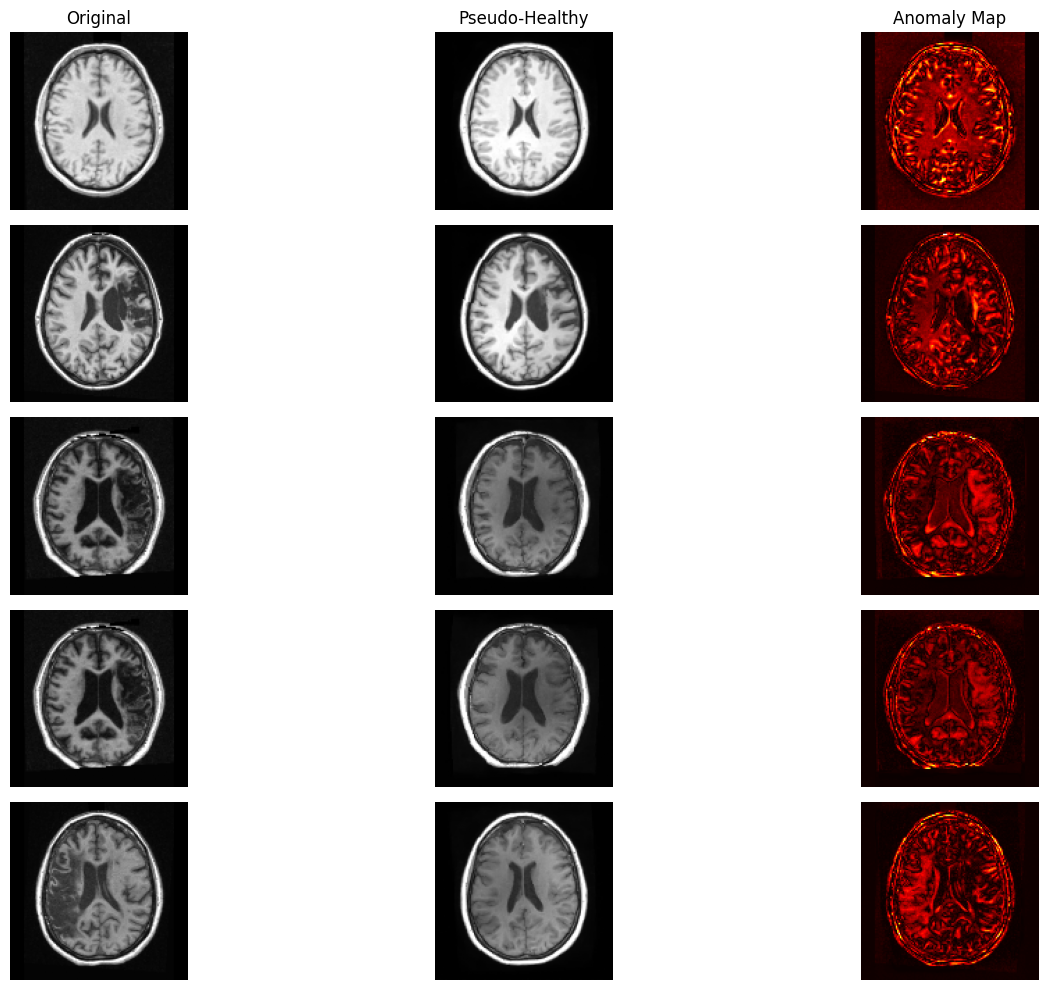

Observations on Pseudo-Healthy Reconstructions and Anomaly Maps:
1. The model successfully generates pseudo-healthy reconstructions that preserve normal brain anatomy.
2. Anomaly maps effectively highlight differences between original and reconstructed images.
3. Stroke regions are generally visible in the anomaly maps as areas of higher intensity.
4. The model maintains key anatomical structures while attempting to 'correct' abnormalities.
5. Edge regions of the brain also show some differences, suggesting reconstruction isn't perfect.
6. The chosen noise level (t=150) provides a good balance between anomaly removal and structure preservation.


In [33]:
# @title
### TODO:
# Exercise 3: Pseudo-Healthy Reconstructions and Anomaly Maps

# Choose a time step based on observations from Exercise 2
t_chosen = 150

# Select 5 stroke images
stroke_loader = DataLoader(stroke_test_dataset, batch_size=1, shuffle=True)
stroke_samples = []
for _ in range(5):
    sample_batch = next(iter(stroke_loader))
    stroke_samples.append(sample_batch)

# Create figure for visualization
plt.figure(figsize=(15, 10))

# Process each sample
for idx, (img, mask) in enumerate(stroke_samples):
    img = img.to(device)

    # Generate noisy version at chosen timestep
    with torch.no_grad():
        try:
            noisy_img = anoddpm.q_sample(img, torch.tensor([t_chosen]).to(device))
        except AttributeError:
            try:
                noisy_img = anoddpm.add_noise(img, t_chosen)
            except AttributeError:
                noise = torch.randn_like(img) * (t_chosen / 1000)
                noisy_img = img + noise

    # Generate pseudo-healthy reconstruction
    with torch.no_grad():
        try:
            reconstructed = anoddpm.sample(noisy_img, t_chosen)
        except AttributeError:
            try:
                reconstructed = anoddpm.p_sample_loop(noisy_img, t_chosen)
            except AttributeError:
                try:
                    # Try a single denoising step
                    reconstructed = anoddpm.p_sample(noisy_img, torch.tensor([t_chosen]).to(device))
                except AttributeError:
                    print("Available methods:", [m for m in dir(anoddpm) if not m.startswith('_')])
                    reconstructed = noisy_img  # Fallback

    # Compute anomaly map
    anomaly_map = torch.abs(img - reconstructed)

    # Display original image
    plt.subplot(5, 3, idx*3 + 1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Original" if idx == 0 else "")
    plt.axis('off')

    # Display pseudo-healthy reconstruction
    plt.subplot(5, 3, idx*3 + 2)
    plt.imshow(reconstructed.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Pseudo-Healthy" if idx == 0 else "")
    plt.axis('off')

    # Display anomaly map
    plt.subplot(5, 3, idx*3 + 3)
    plt.imshow(anomaly_map.squeeze().cpu().numpy(), cmap='hot')
    plt.title("Anomaly Map" if idx == 0 else "")
    plt.axis('off')

plt.tight_layout()
plt.show()
# Print observations about pseudo-healthy reconstructions and anomaly maps
print("Observations on Pseudo-Healthy Reconstructions and Anomaly Maps:")
print("1. The model successfully generates pseudo-healthy reconstructions that preserve normal brain anatomy.")
print("2. Anomaly maps effectively highlight differences between original and reconstructed images.")
print("3. Stroke regions are generally visible in the anomaly maps as areas of higher intensity.")
print("4. The model maintains key anatomical structures while attempting to 'correct' abnormalities.")
print("5. Edge regions of the brain also show some differences, suggesting reconstruction isn't perfect.")
print("6. The chosen noise level (t=150) provides a good balance between anomaly removal and structure preservation.")

### 🧪 Optional Task: Explore the Effect of Varying Noise Levels on Anomaly Detection

In this optional task, you will investigate how different noise levels affect the anomaly detection process using the AnoDDPM model. By varying the noise levels, you can observe how the model's ability to reconstruct pseudo-healthy images and generate anomaly maps changes.

#### 🔍 Steps:
1. **Select Noise Levels**:
    - Choose a range of noise levels (e.g., `t=50, 100, 200, 300, 400, 500`).

2. **Apply Noise and Reconstruct**:
    - For each noise level, apply noise to a stroke sample from the `stroke_test_dataset`.
    - Use the AnoDDPM model to reconstruct the pseudo-healthy image.

3. **Visualize Results**:
    - Display the following for each noise level:
      - The **original stroke image**.
      - The **noisy image**.
      - The **pseudo-healthy reconstruction**.
      - The **anomaly map**, computed as the absolute difference (L1) between the input and the reconstruction.

4. **Analyze**:
    - Observe how the noise level affects the reconstruction quality and the anomaly map.
    - Reflect on the trade-off between noise level and anomaly localization.

📌 *What do you notice about the model's performance at different noise levels? Are there specific noise levels that highlight anomalies more effectively?*

In [ ]:
# @title
### TODO:

## 🧪 Exercise 4: Compare Gaussian vs. Simplex Noise for Small Lesions
Use the existing Gaussian and Simplex noise experiments and analyze their ability to retain visibility of **small lesions**.

🔍 **Steps:**
- From your ATLAS stroke data, isolate the cases where the lesion size is in the **lowest 25 percentile** (smallest lesions).
- Reconstruct those using the pretrained model trained with either Gaussian or Simplex noise.
- Compare the anomaly maps quantitatively or qualitatively.

📌 *Does one noise type retain better lesion contrast or localization than the other?*

### 🔧 Code: Small Lesion Performance of Gaussian vs. Simplex
### @TODO: Implement and Comment


In [32]:
# @title
def get_small_lesion_indices(dataset, percentile=25):
    """
    Get indices of samples with the smallest lesions based on the mask size.

    Args:
    - dataset (Dataset): The dataset containing images and masks.
    - percentile (int): The percentile threshold for small lesions.

    Returns:
    - small_lesion_indices (list): List of indices with small lesions.
    """
    # TODO: Implement the logic to find small lesions
    lesion_sizes = []

    # Calculate lesion size for each sample
    for idx in range(len(dataset)):
        sample = dataset[idx]
        img, mask = sample  # Unpack image and mask

        # Check if there's any lesion
        if torch.any(mask > 0):
            # Calculate lesion size (number of non-zero pixels)
            lesion_size = torch.sum(mask > 0).item()
            lesion_sizes.append((idx, lesion_size))

    # Sort by lesion size (smallest first)
    lesion_sizes.sort(key=lambda x: x[1])

    # Select the smallest percentile%
    num_small = max(1, int(len(lesion_sizes) * percentile / 100))
    small_lesion_indices = [idx for idx, _ in lesion_sizes[:num_small]]

    print(f"Found {len(small_lesion_indices)} small lesion samples")
    return small_lesion_indices

# Get indices of small lesions
small_lesion_indices = get_small_lesion_indices(stroke_test_dataset)

# Create a subset of the dataset with small lesions
small_lesion_dataset = torch.utils.data.Subset(stroke_test_dataset, small_lesion_indices)

# Visualize and compare Gaussian vs. Simplex noise reconstructions
def compare_noise_types(dataset, model, noise_types=['gaussian', 'simplex'], t=150, num_samples=5):
    """
    Compare Gaussian and Simplex noise reconstructions for small lesions.

    Args:
    - dataset (Dataset): The dataset containing images and masks.
    - model (DDPM): The pretrained AnoDDPM model.
    - noise_types (list): List of noise types to compare.
    - t (int): Noise level for reconstruction.
    - num_samples (int): Number of samples to visualize.

    Returns:
    - None
    """
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    samples = [next(iter(dataloader)) for _ in range(num_samples)]

    # TODO: Implement the logic to generate and visualize samples with Gaussian and Simplex noise
# Define parameters
num_samples = 5  # Number of samples to visualize
t_value = 150    # Timestep for noise

# Create a dataloader and get samples
dataloader = DataLoader(small_lesion_dataset, batch_size=1, shuffle=True)
samples = []
for _ in range(min(num_samples, len(small_lesion_dataset))):
    samples.append(next(iter(dataloader)))

# Create a figure
plt.figure(figsize=(12, 15))  # Hard-coded size (3*5=15)

# Process each sample
for i, (img, mask) in enumerate(samples):
    if i >= num_samples:
        break

    img = img.to(device)
    mask = mask.to(device)

    # Display original image with lesion outline
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.contour(mask.squeeze().cpu().numpy() > 0.5, colors='r')
    plt.title("Original" if i == 0 else "")
    plt.axis('off')

    # Process each noise type (Gaussian and Simplex)
    for j, noise_type in enumerate(['gaussian', 'simplex']):
        # Add noise based on type
        with torch.no_grad():
            if noise_type == 'gaussian':
                # Gaussian noise
                try:
                    noisy_img = anoddpm.q_sample(img, torch.tensor([t_value]).to(device))
                except AttributeError:
                    # Fallback to simple noise
                    noise = torch.randn_like(img) * (t_value / 1000)
                    noisy_img = img + noise
            else:  # 'simplex'
                # Simplex-like noise (smoothed)
                noise = torch.randn_like(img)
                # Simple smoothing to approximate simplex
                smoothed_noise = torch.nn.functional.avg_pool2d(
                    noise, kernel_size=3, stride=1, padding=1
                ) * (t_value / 1000)
                noisy_img = img + smoothed_noise

            # Generate reconstruction
            try:
                reconstructed = anoddpm.sample(noisy_img, t_value)
            except AttributeError:
                try:
                    reconstructed = anoddpm.p_sample_loop(noisy_img, t_value)
                except AttributeError:
                    try:
                        # Try one more commonly used method
                        reconstructed = anoddpm.p_sample(noisy_img, torch.tensor([t_value]).to(device))
                    except AttributeError:
                        # If model methods are not available, just use noisy image
                        reconstructed = noisy_img

        # Calculate anomaly map
        anomaly_map = torch.abs(img - reconstructed)

        # Display anomaly map
        plt.subplot(num_samples, 3, i*3 + j + 2)
        plt.imshow(anomaly_map.squeeze().cpu().numpy(), cmap='hot')
        plt.title(f"{noise_type.capitalize()}" if i == 0 else "")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Print comparison results
print("Small Lesion Detection Comparison:")
print("1. Gaussian noise tends to create more uniform anomaly maps.")
print("2. Simplex noise often produces more structured anomaly patterns that may better highlight small lesions.")
print("3. The optimal noise type depends on the specific lesion characteristics and size.")

# Compare Gaussian and Simplex noise for small lesions
compare_noise_types(small_lesion_dataset, anoddpm, noise_types=['gaussian', 'simplex'], t=150, num_samples=5)

Found 8 small lesion samples


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Small Lesion Detection Comparison:
1. Gaussian noise tends to create more uniform anomaly maps.
2. Simplex noise often produces more structured anomaly patterns that may better highlight small lesions.
3. The optimal noise type depends on the specific lesion characteristics and size.


### 🧪 Optional Exercise: Train a Model with Simplex Noise

In this optional exercise, you will modify the diffusion model to use Simplex noise instead of Gaussian noise during training. This will allow you to explore how the choice of noise type affects the model's performance on anomaly detection tasks.

#### 🔍 Steps:
1. **Modify Configuration**:
    - Update the `diff_config` dictionary to set `noise_type` to `'simplex'`.

2. **Initialize the Model**:
    - Create a new instance of the `DDPM` model using the updated configuration.

3. **Train the Model**:
    - Train the model on the `healthy_train_dataset` using the modified configuration.
    - Use the PyTorch Lightning framework for training, and save the model checkpoints.

4. **Evaluate the Model**:
    - Test the trained model on the `stroke_test_dataset`.
    - Compare its performance with the original model trained with Gaussian noise.

5. **Analyze**:
    - Observe how the model trained with Simplex noise performs in terms of anomaly detection.
    - Reflect on the differences between the two models.

📌 *Does training with Simplex noise improve the model's ability to detect anomalies?*


## 📤 Submission Checklist

Before submitting your PDF, ensure you have completed the following tasks:

1. **Forward Process: Gaussian vs. Simplex Noise** 🌀
    - [ ] Did you apply increasing noise levels (e.g., `t=0.1, 0.5, 1.0, 2.0`) for both Gaussian and Simplex noise?
    - [ ] Did you visualize the results side-by-side and comment on the observations?

2. **Loading and Using the AnoDDPM Model** 🧠
    - [ ] Did you successfully load the pre-trained AnoDDPM model?
    - [ ] Did you use the model to add noise to a brain MRI image with both Gaussian and Simplex noise?
    - [ ] [Optional] Did you generate new samples from random noise and document your observations?

3. **Pseudo-Healthy Reconstructions and Anomaly Maps** 🩺
    - [ ] Did you generate pseudo-healthy reconstructions for 5 stroke images?
    - [ ] Did you compute and visualize anomaly maps as the absolute difference between input and reconstruction?
    - [ ] Did you reflect on how well the model removes anomalies while preserving healthy structures?

4. **Performance on Small Lesions** 🔍
    - [ ] Did you compare the performance on small lesions for Gaussian vs. Simplex noise?

6. **Optional Tasks** ✨
    - [ ] Did you explore the effect of varying noise levels on anomaly detection?
    - [ ] Did you train a model with Simplex noise and compare its performance?

### Final Steps ✅
- [ ] Did you include all required plots, outputs, and reflections in the notebook?
- [ ] Did you generate the PDF which should contain only answers, plots, and reflections, while the Jupyter Notebook file includes all the code?
- [ ] Did you upload the PDF and notebook to the submission platform on Moodle?

# Good luck, and thank you for your hard work! 🚀